# Metropolis-Hastings

##### Keywords: metropolis-hastings, MCMC,  detailed balance, discrete sampling, transition matrix, metropolis

In [7]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')

## Contents
{:.no_toc}
* 
{: toc}

## Metropolis-Hastings

If you want to sample a distribution with limited or only positive support, you realize that a normal distribution as a proposal will still want  to sample stuff in negative areas and outside the max support.  So we wastefully make acceptance probability comparisons.

Out intuition may be to reject samples outside the support. But as we shall show later, this makes our proposal asymmetric and we need to deal with this. This is because stepping to a negative number and coming back are not symmetric: one is rejected.

If we do it without taking into account this asymmetry, we will actually be sampling from a different distribution as we shall show later.

However, we may also want to sample from a asymmetric proposal like a beta function because its guaranteed to be positive.  However  a beta distribution is not symmetric.

Thus Metropolis Hastings allows us to sample distributions that are defined on  limited support. 

Here is the outline code for metropolis hastings.

In [102]:
def metropolis_hastings(p,q, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    accepted=0
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star)/q(x_star, x_prev)
        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples[i] = x_star
            x_prev = x_star
            accepted +=1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted

Compare it with the code for metropolis

In [153]:
def metropolis(p, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    accepted=0
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        #print(x_star, pdfratio)
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
            accepted +=1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted

### Proof of detailed balance

The transition matrix (or kernel) can be written in this form for Metropolis-Hastings is also:

$$T(x_i \vert x_{i-1}) = q(x_i \vert x_{i-1})\,A(x_i, x_{i-1}) +  \delta(x_{i-1} - x_i)r(x_{i-1})$$

where now the acceptance probability has changed to:

$$A(x_i, x_{i-1}) = min(1,  \frac{s(x_i) \times q(x_{i-1} \vert x_i)}{s(x_{i-1}) \times q(x_i \vert x_{i-1})}).$$ 

Everything else remains the same with the rejection term still:

$$r(x_i) = \int dy q(y \vert x_i)(1 - A(y, x_i)) = 1 - \int dy q(y \vert x_i) A(y, x_i).$$ 


Now, as in the Metropolis case, consider:

$$s(x_i)T( x_{i-1} \vert x_i ) =  s(x_i) q(x_{i-1} \vert x_{i})\,A(x_{i-1}, x_{i}) +  s(x_i) \delta(x_{i} - x_{i-1})r(x_{i})$$

and 

$$s(x_{i-1})T( x_{i} \vert x_{i-1} ) =  s(x_{i-1}) q(x_i \vert x_{i-1})\,A(x_i, x_{i-1}) +  s(x_{i-1})\delta(x_{i-1} - x_i)r(x_{i-1})$$

The second terms cancel.

The comparison of the first two terms is just a bit harder than in the Metropolis case, but the cases are the same. The first two terms are trivially equal when A=1 because the proposal-ration must be 1. If  $s(x_i) \times q(x_{i-1} \vert x_i) <  s(x_{i-1}) \times q(x_i \vert x_{i-1})$ then $A(x_i, x_{i-1}) < 1$ and  $A(x_{i-1}, x_{i}) = 1$.

Then we are comparing:

$$\frac{s(x_i) \times q(x_{i-1} \vert x_i)}{s(x_{i-1}) \times q(x_i \vert x_{i-1})} \times  s(x_{i-1}) q(x_i \vert x_{i-1})$$

to $s(x_i) q(x_{i-1} \vert x_{i})$ which are again trivially equal.



The intuition behind this, is to correct the sampling of $q$ to match $p$. It corrects for any asymmetries in the proposal distribution. If the proposal prefers left over right, then we weigh the rightward moves more.

In the case of distributions with limited support (only positives, for example) one must be careful choosing a proposal. A good rule of thumb is that the proposal has the same or larger support then the target, with the same support being the best. 

## MH example

Let us sample from  $f(x)=0.554xe^{-(x/1.9)^2}$ which is a weibull distribution used in response time analysis.

In [104]:
f = lambda x: 0.554*x*np.exp(-(x/1.9)**2)

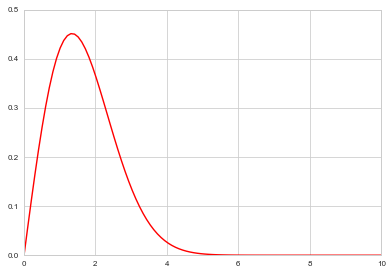

In [106]:
xxx= np.linspace(0,10,100)
plt.plot(xxx, f(xxx), 'r');

A rule of thumb for choosing proposal distributions is to parametrize them in terms of their mean and variance or precision since that  provides a notion of "centeredness" which we can use for our proposals $x_{i-1}$. We then fix the variance to understand how widely we are sampling from.

As a proposal we shall use a Gamma Distribution with parametrization $$Gamma(x\tau, 1/\tau)$$ in the shape-scale parametrization. The mean of this Gamma then is $shape*scale$ so that x is the mean. $\tau$ is a precision parameter


In [107]:
from scipy.stats import gamma
t=10
def gammapdf(x_new, x_old):
    return gamma.pdf(x_new,x_old*t,scale=1/t)
def gammadraw(x_old):
    return gamma.rvs(x_old*t,scale=1/t)
        

In [108]:
x0=np.random.uniform()
samps,acc = metropolis_hastings(f, gammapdf, gammadraw, 100000, x0)

In [109]:
acc

83244

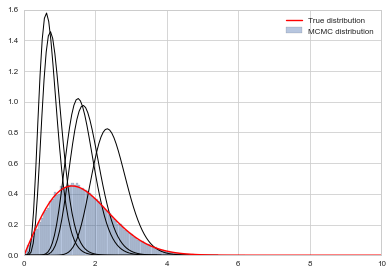

starting point was  0.9847232294704866


In [110]:
# plot our sample histogram
plt.hist(samps,bins=100, alpha=0.4, label=u'MCMC distribution', normed=True) 
somesamps=samps[0::20000]
for i,s in enumerate(somesamps):
    xs=np.linspace(s-3, s+3, 100)
    plt.plot(xs, gamma.pdf(xs,s*t,scale=1/t),'k', lw=1)
xx= np.linspace(0,10,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()
plt.xlim([0,10])
plt.show()
print("starting point was ", x0)

Remember how we said that it takes some time for the Markov chain to reach a stationary state? We should remove the samples until that point. We can see the progress of the samples using a trace-plot

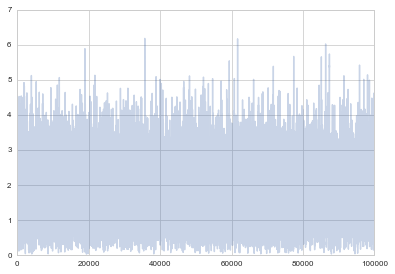

In [191]:
plt.plot(samps, alpha=0.3);

(0, 5000)

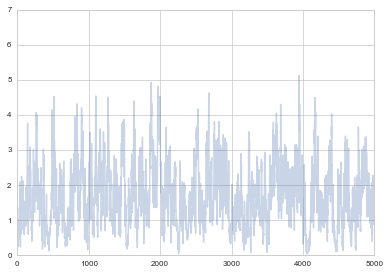

In [188]:
plt.plot(samps, alpha=0.3);
plt.xlim([0, 5000])

The first many samples will contain  signs of the initial condition, and will also reflect the fact that you have not found the stationary distribution as yet. We will see tests later for this, but as a rule of thumb, you always want to eliminate the first 5-10% of your samples. The appearance of **white noise** is a good sign.

(20000, 25000)

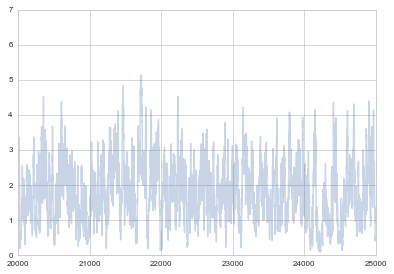

In [190]:
plt.plot(samps, alpha=0.3);
plt.xlim([20000, 25000])

Notice that strong autocorrelations persist at high sample number too. This is the nature of metropolis and MH samplers..your next move is clearly highly correlated with the previous one.

This is not a disaster in itself, but many people will thin their samples to have samples uncorrelated. Here I am leaving out a burnin of 20000, and am thinning to every 10.

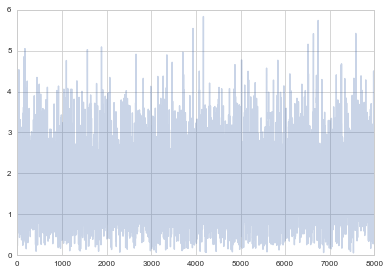

In [184]:
plt.plot(samps[20000::10], alpha=0.3);

Here is the last 8000 samples for comparison where you can clearly see correlations. We shall talk more about these considerations later.

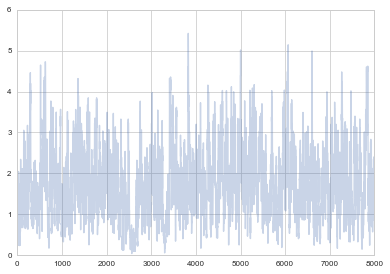

In [185]:
plt.plot(samps[-8000:], alpha=0.3);

### The same function with Metropolis

We could do the same thing with a normal, and using metropolis


In [116]:
def prop(x):
    return np.random.normal(x, 0.6)
samps_m, acc_m = metropolis(f, prop, 100000, x0)

In [117]:
acc_m

79092

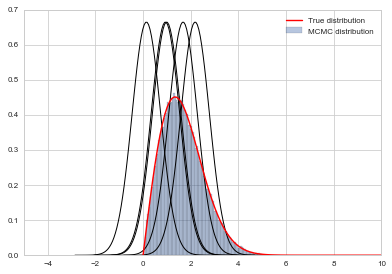

starting point was  0.9847232294704866


In [118]:
plt.hist(samps_m,bins=100, alpha=0.4, label=u'MCMC distribution', normed=True) 
somesamps=samps_m[0::20000]
for i,s in enumerate(somesamps):
    xs=np.linspace(s-3, s+3, 100)
    plt.plot(xs, norm.pdf(xs,s,0.6),'k', lw=1)
xx= np.linspace(0,10,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()
plt.xlim([-5,10])
plt.show()
print("starting point was ", x0)

I havent tuned either to get up the acceptance rates. It is a game you ought to play. A good proposal should have the acceptance rate neither too high nor too low. The former means the proposal is likely too narrow, while the latter means the proposal is likely too wide.

## Rainy Sunny Reprise

To show how we can use Metropolis Hastings to  sample a discrete distribution, let us go back to our rainy sunny example from Markov Chains.

There, given a transition matrix, we found a corresponding stationary distribution for it. Here we weant to fix the stationary distribution, and somehow let metropolis-hastings find the appropriate transition matrix to get us there.

In [123]:
# the transition matrix for our chain
transition_matrix = np.array([[0.3, 0.7],[0.5, 0.5]])

print("The transition matrix")
print(transition_matrix)

print("Stationary distribution")
print(np.linalg.matrix_power(transition_matrix,10))

The transition matrix
[[ 0.3  0.7]
 [ 0.5  0.5]]
Stationary distribution
[[ 0.41666673  0.58333327]
 [ 0.41666662  0.58333338]]


To sample from this, we need our final stationary pdf, which is a Bernoulli with p=0.416667. This is thus a kind of fake problem because knowing the pdf for a bernoulli, we can sample from it directly by using a uniform. But thats not our point here..

In [146]:
def rainsunpmf(state_int):
    p = 0.416667
    if state_int==0:
        return p
    else:#anything else is treated as a 1
        return 1 - p

Now, any move that transitions us from state 0 to state 1 and back would work.  In particular, we could use a symmetric transition matrix and then use plain metropolis.

You might find it strange that we are calling the proposal a transition matrix. This is strictly an abuse of terminology. We just need anything that will get us a set of probablities that sum to 1 and is symettric!

In [147]:
t_sym = np.array([[0.1, 0.9],[0.9, 0.1]])
def rainsunprop(sint_old):
    return np.random.choice(2,p=t_sym[sint_old])

In [154]:
samps_dis, acc_dis = metropolis(rainsunpmf, rainsunprop, 1000, 1)

In [155]:
acc_dis

848

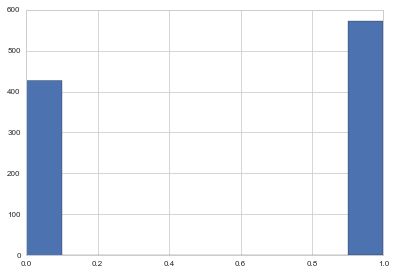

In [157]:
plt.hist(samps_dis);

If I wish to use metropolis hastings I  can choose an asymmetric proposal and I must provide a proposal pdf.

In [158]:
t_asym = np.array([[0.1, 0.9],[0.3, 0.7]])
def rainsunprop2(sint_old):
    return np.random.choice(2,p=t_asym[sint_old])

In [192]:
t_asym

array([[ 0.1,  0.9],
       [ 0.3,  0.7]])

In [160]:
t_asym[0][1]

0.90000000000000002

In [161]:
def rainsunpropfunc(sint_new, sint_old):
    return t_asym[sint_old][sint_new]

In [162]:
samps_dis2, acc_dis2 = metropolis_hastings(rainsunpmf, rainsunpropfunc, rainsunprop2, 1000, 1)

In [163]:
acc_dis2

797

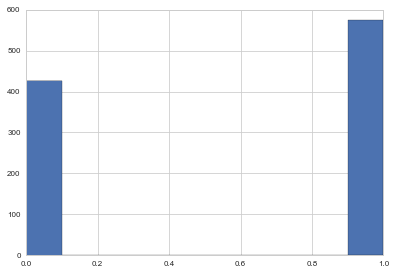

In [164]:
plt.hist(samps_dis2);